<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Alzheimer%E2%80%99s_Dementia_Speech_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub

In [2]:
import os
import tarfile
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.silence import split_on_silence
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import uuid
from pathlib import Path

In [3]:
# Step 1: Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to the .tgz files
data_path = '/content/drive/MyDrive/Voice/ADRESS021/'
train_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-train.tgz')
test_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-test.tgz')
train_diag_tgz = os.path.join(data_path, 'ADRESS021-diagnosis-train.tgz')

# Extract .tgz files
extracted_path = '/content/adress021_data/'
os.makedirs(extracted_path, exist_ok=True)

Mounted at /content/drive


In [4]:
import tarfile
import glob
import os

# Define file paths
train_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz'
test_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz'
train_diag_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz'
extracted_path = '/content/extracted_audio'  # Directory to extract files to

# Ensure extracted_path exists
os.makedirs(extracted_path, exist_ok=True)

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path} to {extract_to}")
    except FileNotFoundError:
        print(f"Error: File {tgz_path} not found.")
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")

# Extract each .tgz file
for tgz in [train_prog_tgz, test_prog_tgz, train_diag_tgz]:
    if os.path.exists(tgz):
        extract_tgz(tgz, extracted_path)
    else:
        print(f"Skipping {tgz}: File does not exist.")

# Find all WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio
Found 271 audio files.


In [5]:
# Load metadata (assuming there's a CSV or text file with labels)
# Modify this based on actual metadata structure
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    print("Metadata loaded:")
    print(metadata.head())
else:
    metadata = pd.DataFrame({'file': audio_files, 'label': 'unknown'})
    print("No metadata CSV found. Using file paths only.")

Metadata loaded:
   Unnamed: 0 speaker  begin    end
0           1     INV  30000  32108
1           2     PAR  32108  33057
2           3     INV  33057  35367
3           4     PAR  35367  38537
4           5     PAR  38537  40233


In [13]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load metadata
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if not metadata_path:
    raise FileNotFoundError("No metadata CSV found in extracted path.")

# Inspect available CSV files
print("Found CSV files:", metadata_path)

# Load and inspect the first CSV to check columns
metadata = pd.read_csv(metadata_path[0])
print("Metadata columns:", metadata.columns.tolist())
print("Metadata preview:")
print(metadata.head())

# Check for required columns
required_columns = ['adressfname', 'dx', 'mmse']
if not all(col in metadata.columns for col in required_columns):
    print(f"Error: Required columns {required_columns} not found in {metadata_path[0]}")
    # Try to find the correct CSV
    for csv_path in metadata_path:
        temp_metadata = pd.read_csv(csv_path)
        if all(col in temp_metadata.columns for col in required_columns):
            metadata = temp_metadata
            print(f"Found correct metadata in {csv_path}")
            break
    else:
        raise ValueError("No CSV file contains required columns: 'adressfname', 'dx', 'mmse'")

# Ensure 'dx' is string
metadata['dx'] = metadata['dx'].astype(str)

# Step 2: Find WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# Step 3: Match audio files with metadata
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0]
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"Matched {len(audio_metadata)} audio files with metadata.")

# # Step 4: Limit to a subset for testing
# subset_size = 10  # Adjust as needed
# audio_metadata = audio_metadata[:subset_size]
# print(f"Processing {len(audio_metadata)} files for testing.")

Found CSV files: ['/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp179.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp101.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp266.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp300.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp313.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp051.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp003.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp127.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp209.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/decline/adrsp055.csv', '/content/extracted_audio/ADReSSo21/progression/train/segmentation/no_decline/adrs

In [14]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Metadata is already loaded from your output
# Assuming metadata is now correctly loaded from adresso-train-mmse-scores.csv
# audio_metadata contains 10 files for testing
print("Audio metadata preview:")
print(audio_metadata.head())

# Preprocessing function for a single audio file
def process_audio(audio_file, sr=16000, skip_noise_removal=True):
    try:
        # Load audio
        y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)

        # Skip noise removal to save time on CPU
        y_processed = y if skip_noise_removal else librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine')

        # Trim silence
        y_trimmed, _ = librosa.effects.trim(y_processed, top_db=20)

        # Feature Extraction
        # Acoustic: MFCCs (reduced to 13 for CPU efficiency)
        mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Prosodic: Pitch, Energy
        pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
        pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        energy = np.mean(librosa.feature.rms(y=y_trimmed))

        # Linguistic: Placeholder (requires ASR)
        linguistic_features = np.array([0, 0])

        # Combine features
        features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])

        return y_trimmed, features
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None, None

# Process all files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    y_trimmed, features = process_audio(row['file'])
    if y_trimmed is None or features is None:
        continue

    # Save processed audio
    output_path = os.path.join(output_dir, os.path.basename(row['file']))
    sf.write(output_path, y_trimmed, 16000)

    processed_features.append(features)
    processed_audio_paths.append(output_path)
    labels.append(row['label'])

    print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")

# Convert to numpy arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"Extracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Feature Normalization
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)

    # Data Augmentation (simple noise addition)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)

    # Export Features
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)

    # Save processed audio file list and metadata
    audio_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_audio_paths:
            f.write(f"{path}\n")

    print(f"Features and metadata saved to {output_dir}")
else:
    print("No features extracted. Check audio files and metadata matching.")

Audio metadata preview:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    23
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    19
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    10
4  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    20


Processing audio files:   1%|          | 1/166 [00:00<01:25,  1.94it/s]

Processed: adrso228.wav (Label: ad)


Processing audio files:   1%|          | 2/166 [00:01<01:53,  1.45it/s]

Processed: adrso055.wav (Label: ad)


Processing audio files:   2%|▏         | 3/166 [00:03<03:06,  1.14s/it]

Processed: adrso200.wav (Label: ad)


Processing audio files:   2%|▏         | 4/166 [00:03<02:41,  1.00it/s]

Processed: adrso229.wav (Label: ad)


Processing audio files:   3%|▎         | 5/166 [00:04<02:43,  1.02s/it]

Processed: adrso220.wav (Label: ad)


Processing audio files:   4%|▎         | 6/166 [00:06<02:51,  1.07s/it]

Processed: adrso043.wav (Label: ad)


Processing audio files:   4%|▍         | 7/166 [00:07<02:53,  1.09s/it]

Processed: adrso211.wav (Label: ad)


Processing audio files:   5%|▍         | 8/166 [00:08<03:27,  1.31s/it]

Processed: adrso116.wav (Label: ad)


Processing audio files:   5%|▌         | 9/166 [00:11<04:11,  1.60s/it]

Processed: adrso049.wav (Label: ad)


Processing audio files:   6%|▌         | 10/166 [00:11<03:14,  1.25s/it]

Processed: adrso125.wav (Label: ad)


Processing audio files:   7%|▋         | 11/166 [00:12<02:45,  1.07s/it]

Processed: adrso031.wav (Label: ad)


Processing audio files:   7%|▋         | 12/166 [00:12<02:17,  1.12it/s]

Processed: adrso123.wav (Label: ad)


Processing audio files:   8%|▊         | 13/166 [00:13<02:08,  1.19it/s]

Processed: adrso138.wav (Label: ad)


Processing audio files:   8%|▊         | 14/166 [00:14<01:56,  1.31it/s]

Processed: adrso247.wav (Label: ad)


Processing audio files:   9%|▉         | 15/166 [00:14<01:44,  1.45it/s]

Processed: adrso070.wav (Label: ad)


Processing audio files:  10%|▉         | 16/166 [00:15<01:31,  1.64it/s]

Processed: adrso060.wav (Label: ad)


Processing audio files:  10%|█         | 17/166 [00:15<01:37,  1.52it/s]

Processed: adrso248.wav (Label: ad)


Processing audio files:  11%|█         | 18/166 [00:16<01:31,  1.61it/s]

Processed: adrso245.wav (Label: ad)


Processing audio files:  11%|█▏        | 19/166 [00:16<01:29,  1.64it/s]

Processed: adrso224.wav (Label: ad)


Processing audio files:  12%|█▏        | 20/166 [00:17<01:20,  1.81it/s]

Processed: adrso059.wav (Label: ad)


Processing audio files:  13%|█▎        | 21/166 [00:18<01:28,  1.64it/s]

Processed: adrso197.wav (Label: ad)


Processing audio files:  13%|█▎        | 22/166 [00:18<01:11,  2.03it/s]

Processed: adrso142.wav (Label: ad)


Processing audio files:  14%|█▍        | 23/166 [00:18<01:15,  1.90it/s]

Processed: adrso039.wav (Label: ad)


Processing audio files:  14%|█▍        | 24/166 [00:19<01:28,  1.60it/s]

Processed: adrso233.wav (Label: ad)


Processing audio files:  15%|█▌        | 25/166 [00:21<01:59,  1.18it/s]

Processed: adrso078.wav (Label: ad)


Processing audio files:  16%|█▌        | 26/166 [00:22<02:10,  1.07it/s]

Processed: adrso027.wav (Label: ad)


Processing audio files:  16%|█▋        | 27/166 [00:22<01:55,  1.20it/s]

Processed: adrso141.wav (Label: ad)


Processing audio files:  17%|█▋        | 28/166 [00:24<02:18,  1.01s/it]

Processed: adrso090.wav (Label: ad)


Processing audio files:  17%|█▋        | 29/166 [00:25<02:16,  1.01it/s]

Processed: adrso106.wav (Label: ad)


Processing audio files:  18%|█▊        | 30/166 [00:25<01:58,  1.15it/s]

Processed: adrso068.wav (Label: ad)


Processing audio files:  19%|█▊        | 31/166 [00:26<01:45,  1.29it/s]

Processed: adrso234.wav (Label: ad)


Processing audio files:  19%|█▉        | 32/166 [00:26<01:32,  1.45it/s]

Processed: adrso249.wav (Label: ad)


Processing audio files:  20%|█▉        | 33/166 [00:29<02:37,  1.18s/it]

Processed: adrso024.wav (Label: ad)


Processing audio files:  20%|██        | 34/166 [00:31<03:10,  1.44s/it]

Processed: adrso216.wav (Label: ad)


Processing audio files:  21%|██        | 35/166 [00:31<02:30,  1.15s/it]

Processed: adrso189.wav (Label: ad)


Processing audio files:  22%|██▏       | 36/166 [00:32<01:59,  1.09it/s]

Processed: adrso077.wav (Label: ad)


Processing audio files:  22%|██▏       | 37/166 [00:32<01:40,  1.28it/s]

Processed: adrso112.wav (Label: ad)


Processing audio files:  23%|██▎       | 38/166 [00:33<01:33,  1.37it/s]

Processed: adrso218.wav (Label: ad)


Processing audio files:  23%|██▎       | 39/166 [00:33<01:16,  1.66it/s]

Processed: adrso063.wav (Label: ad)


Processing audio files:  24%|██▍       | 40/166 [00:33<01:09,  1.82it/s]

Processed: adrso244.wav (Label: ad)


Processing audio files:  25%|██▍       | 41/166 [00:34<01:09,  1.81it/s]

Processed: adrso212.wav (Label: ad)


Processing audio files:  25%|██▌       | 42/166 [00:34<01:03,  1.96it/s]

Processed: adrso215.wav (Label: ad)


Processing audio files:  26%|██▌       | 43/166 [00:35<00:54,  2.28it/s]

Processed: adrso253.wav (Label: ad)


Processing audio files:  27%|██▋       | 44/166 [00:36<01:15,  1.62it/s]

Processed: adrso053.wav (Label: ad)


Processing audio files:  27%|██▋       | 45/166 [00:36<01:21,  1.48it/s]

Processed: adrso046.wav (Label: ad)


Processing audio files:  28%|██▊       | 46/166 [00:37<01:14,  1.61it/s]

Processed: adrso187.wav (Label: ad)


Processing audio files:  28%|██▊       | 47/166 [00:38<01:13,  1.63it/s]

Processed: adrso032.wav (Label: ad)


Processing audio files:  29%|██▉       | 48/166 [00:38<00:58,  2.03it/s]

Processed: adrso092.wav (Label: ad)


Processing audio files:  30%|██▉       | 49/166 [00:39<01:08,  1.72it/s]

Processed: adrso202.wav (Label: ad)


Processing audio files:  30%|███       | 50/166 [00:39<01:02,  1.85it/s]

Processed: adrso250.wav (Label: ad)


Processing audio files:  31%|███       | 51/166 [00:39<00:57,  2.00it/s]

Processed: adrso028.wav (Label: ad)


Processing audio files:  31%|███▏      | 52/166 [00:40<00:51,  2.21it/s]

Processed: adrso206.wav (Label: ad)


Processing audio files:  32%|███▏      | 53/166 [00:40<00:52,  2.14it/s]

Processed: adrso198.wav (Label: ad)


Processing audio files:  33%|███▎      | 54/166 [00:41<01:13,  1.53it/s]

Processed: adrso025.wav (Label: ad)


Processing audio files:  33%|███▎      | 55/166 [00:42<01:03,  1.75it/s]

Processed: adrso109.wav (Label: ad)


Processing audio files:  34%|███▎      | 56/166 [00:42<00:51,  2.15it/s]

Processed: adrso222.wav (Label: ad)


Processing audio files:  34%|███▍      | 57/166 [00:42<00:45,  2.42it/s]

Processed: adrso074.wav (Label: ad)


Processing audio files:  35%|███▍      | 58/166 [00:43<00:49,  2.17it/s]

Processed: adrso192.wav (Label: ad)


Processing audio files:  36%|███▌      | 59/166 [00:44<01:23,  1.28it/s]

Processed: adrso056.wav (Label: ad)


Processing audio files:  36%|███▌      | 60/166 [00:45<01:16,  1.38it/s]

Processed: adrso209.wav (Label: ad)


Processing audio files:  37%|███▋      | 61/166 [00:45<01:00,  1.73it/s]

Processed: adrso122.wav (Label: ad)


Processing audio files:  38%|███▊      | 63/166 [00:46<00:46,  2.23it/s]

Processed: adrso190.wav (Label: ad)
Processed: adrso075.wav (Label: ad)


Processing audio files:  39%|███▉      | 65/166 [00:46<00:31,  3.21it/s]

Processed: adrso134.wav (Label: ad)
Processed: adrso130.wav (Label: ad)


Processing audio files:  40%|███▉      | 66/166 [00:46<00:27,  3.58it/s]

Processed: adrso036.wav (Label: ad)


Processing audio files:  40%|████      | 67/166 [00:47<00:26,  3.69it/s]

Processed: adrso237.wav (Label: ad)


Processing audio files:  41%|████      | 68/166 [00:47<00:26,  3.75it/s]

Processed: adrso047.wav (Label: ad)


Processing audio files:  42%|████▏     | 69/166 [00:48<00:44,  2.20it/s]

Processed: adrso054.wav (Label: ad)


Processing audio files:  42%|████▏     | 70/166 [00:48<00:38,  2.47it/s]

Processed: adrso093.wav (Label: ad)


Processing audio files:  43%|████▎     | 71/166 [00:48<00:33,  2.82it/s]

Processed: adrso126.wav (Label: ad)


Processing audio files:  43%|████▎     | 72/166 [00:49<00:30,  3.05it/s]

Processed: adrso071.wav (Label: ad)


Processing audio files:  44%|████▍     | 73/166 [00:49<00:29,  3.13it/s]

Processed: adrso144.wav (Label: ad)


Processing audio files:  45%|████▍     | 74/166 [00:49<00:32,  2.81it/s]

Processed: adrso033.wav (Label: ad)


Processing audio files:  45%|████▌     | 75/166 [00:50<00:39,  2.33it/s]

Processed: adrso035.wav (Label: ad)


Processing audio files:  46%|████▌     | 76/166 [00:51<00:43,  2.07it/s]

Processed: adrso223.wav (Label: ad)


Processing audio files:  46%|████▋     | 77/166 [00:51<00:41,  2.13it/s]

Processed: adrso110.wav (Label: ad)


Processing audio files:  47%|████▋     | 78/166 [00:52<01:06,  1.33it/s]

Processed: adrso045.wav (Label: ad)


Processing audio files:  48%|████▊     | 79/166 [00:53<00:57,  1.52it/s]

Processed: adrso205.wav (Label: ad)


Processing audio files:  48%|████▊     | 80/166 [00:53<00:51,  1.67it/s]

Processed: adrso188.wav (Label: ad)


Processing audio files:  49%|████▉     | 81/166 [00:54<00:44,  1.89it/s]

Processed: adrso098.wav (Label: ad)


Processing audio files:  50%|█████     | 83/166 [00:54<00:32,  2.54it/s]

Processed: adrso128.wav (Label: ad)
Processed: adrso072.wav (Label: ad)


Processing audio files:  51%|█████     | 84/166 [00:55<00:31,  2.62it/s]

Processed: adrso232.wav (Label: ad)


Processing audio files:  51%|█████     | 85/166 [00:55<00:27,  2.94it/s]

Processed: adrso246.wav (Label: ad)


Processing audio files:  52%|█████▏    | 86/166 [00:55<00:23,  3.35it/s]

Processed: adrso089.wav (Label: ad)


Processing audio files:  53%|█████▎    | 88/166 [00:55<00:17,  4.39it/s]

Processed: adrso236.wav (Label: ad)
Processed: adrso010.wav (Label: cn)


Processing audio files:  54%|█████▎    | 89/166 [00:56<00:18,  4.07it/s]

Processed: adrso014.wav (Label: cn)


Processing audio files:  54%|█████▍    | 90/166 [00:56<00:20,  3.77it/s]

Processed: adrso015.wav (Label: cn)


Processing audio files:  55%|█████▍    | 91/166 [00:56<00:20,  3.71it/s]

Processed: adrso005.wav (Label: cn)


Processing audio files:  55%|█████▌    | 92/166 [00:57<00:20,  3.54it/s]

Processed: adrso312.wav (Label: cn)


Processing audio files:  56%|█████▌    | 93/166 [00:57<00:20,  3.56it/s]

Processed: adrso307.wav (Label: cn)


Processing audio files:  57%|█████▋    | 94/166 [00:57<00:21,  3.40it/s]

Processed: adrso308.wav (Label: cn)


Processing audio files:  57%|█████▋    | 95/166 [00:57<00:20,  3.52it/s]

Processed: adrso018.wav (Label: cn)


Processing audio files:  58%|█████▊    | 96/166 [00:58<00:20,  3.43it/s]

Processed: adrso021.wav (Label: cn)


Processing audio files:  59%|█████▉    | 98/166 [00:58<00:17,  4.00it/s]

Processed: adrso310.wav (Label: cn)
Processed: adrso016.wav (Label: cn)


Processing audio files:  60%|█████▉    | 99/166 [00:59<00:19,  3.48it/s]

Processed: adrso261.wav (Label: cn)


Processing audio files:  60%|██████    | 100/166 [00:59<00:23,  2.84it/s]

Processed: adrso280.wav (Label: cn)


Processing audio files:  61%|██████    | 101/166 [00:59<00:22,  2.93it/s]

Processed: adrso289.wav (Label: cn)


Processing audio files:  61%|██████▏   | 102/166 [01:00<00:21,  2.97it/s]

Processed: adrso182.wav (Label: cn)


Processing audio files:  62%|██████▏   | 103/166 [01:00<00:25,  2.46it/s]

Processed: adrso274.wav (Label: cn)


Processing audio files:  63%|██████▎   | 104/166 [01:01<00:22,  2.70it/s]

Processed: adrso156.wav (Label: cn)


Processing audio files:  63%|██████▎   | 105/166 [01:01<00:21,  2.86it/s]

Processed: adrso257.wav (Label: cn)


Processing audio files:  64%|██████▍   | 106/166 [01:01<00:18,  3.23it/s]

Processed: adrso008.wav (Label: cn)


Processing audio files:  64%|██████▍   | 107/166 [01:02<00:20,  2.88it/s]

Processed: adrso153.wav (Label: cn)


Processing audio files:  65%|██████▌   | 108/166 [01:02<00:18,  3.11it/s]

Processed: adrso316.wav (Label: cn)


Processing audio files:  66%|██████▌   | 109/166 [01:02<00:18,  3.15it/s]

Processed: adrso281.wav (Label: cn)


Processing audio files:  66%|██████▋   | 110/166 [01:02<00:16,  3.46it/s]

Processed: adrso023.wav (Label: cn)


Processing audio files:  67%|██████▋   | 112/166 [01:03<00:13,  4.15it/s]

Processed: adrso165.wav (Label: cn)
Processed: adrso022.wav (Label: cn)


Processing audio files:  68%|██████▊   | 113/166 [01:03<00:13,  3.86it/s]

Processed: adrso017.wav (Label: cn)


Processing audio files:  69%|██████▊   | 114/166 [01:03<00:13,  3.90it/s]

Processed: adrso273.wav (Label: cn)


Processing audio files:  69%|██████▉   | 115/166 [01:04<00:14,  3.53it/s]

Processed: adrso277.wav (Label: cn)


Processing audio files:  70%|██████▉   | 116/166 [01:04<00:15,  3.19it/s]

Processed: adrso180.wav (Label: cn)


Processing audio files:  70%|███████   | 117/166 [01:04<00:16,  3.00it/s]

Processed: adrso260.wav (Label: cn)


Processing audio files:  71%|███████   | 118/166 [01:05<00:16,  2.90it/s]

Processed: adrso285.wav (Label: cn)


Processing audio files:  72%|███████▏  | 120/166 [01:05<00:12,  3.59it/s]

Processed: adrso186.wav (Label: cn)
Processed: adrso161.wav (Label: cn)


Processing audio files:  73%|███████▎  | 121/166 [01:06<00:14,  3.01it/s]

Processed: adrso315.wav (Label: cn)


Processing audio files:  73%|███████▎  | 122/166 [01:06<00:15,  2.83it/s]

Processed: adrso154.wav (Label: cn)


Processing audio files:  74%|███████▍  | 123/166 [01:07<00:17,  2.51it/s]

Processed: adrso151.wav (Label: cn)


Processing audio files:  75%|███████▍  | 124/166 [01:07<00:16,  2.56it/s]

Processed: adrso309.wav (Label: cn)


Processing audio files:  75%|███████▌  | 125/166 [01:07<00:16,  2.48it/s]

Processed: adrso298.wav (Label: cn)


Processing audio files:  76%|███████▌  | 126/166 [01:08<00:15,  2.65it/s]

Processed: adrso169.wav (Label: cn)


Processing audio files:  77%|███████▋  | 127/166 [01:08<00:15,  2.59it/s]

Processed: adrso270.wav (Label: cn)


Processing audio files:  77%|███████▋  | 128/166 [01:08<00:13,  2.74it/s]

Processed: adrso177.wav (Label: cn)


Processing audio files:  78%|███████▊  | 129/166 [01:09<00:14,  2.51it/s]

Processed: adrso164.wav (Label: cn)


Processing audio files:  78%|███████▊  | 130/166 [01:09<00:14,  2.49it/s]

Processed: adrso148.wav (Label: cn)


Processing audio files:  79%|███████▉  | 131/166 [01:10<00:13,  2.58it/s]

Processed: adrso291.wav (Label: cn)


Processing audio files:  80%|████████  | 133/166 [01:10<00:09,  3.41it/s]

Processed: adrso152.wav (Label: cn)
Processed: adrso300.wav (Label: cn)


Processing audio files:  81%|████████  | 134/166 [01:10<00:08,  3.95it/s]

Processed: adrso003.wav (Label: cn)


Processing audio files:  81%|████████▏ | 135/166 [01:11<00:09,  3.26it/s]

Processed: adrso259.wav (Label: cn)


Processing audio files:  83%|████████▎ | 137/166 [01:11<00:08,  3.55it/s]

Processed: adrso283.wav (Label: cn)
Processed: adrso262.wav (Label: cn)


Processing audio files:  83%|████████▎ | 138/166 [01:11<00:07,  3.82it/s]

Processed: adrso160.wav (Label: cn)


Processing audio files:  84%|████████▎ | 139/166 [01:12<00:07,  3.77it/s]

Processed: adrso012.wav (Label: cn)


Processing audio files:  84%|████████▍ | 140/166 [01:12<00:10,  2.56it/s]

Processed: adrso276.wav (Label: cn)


Processing audio files:  85%|████████▍ | 141/166 [01:13<00:09,  2.66it/s]

Processed: adrso158.wav (Label: cn)


Processing audio files:  86%|████████▌ | 142/166 [01:13<00:07,  3.02it/s]

Processed: adrso159.wav (Label: cn)


Processing audio files:  86%|████████▌ | 143/166 [01:13<00:07,  3.07it/s]

Processed: adrso173.wav (Label: cn)


Processing audio files:  87%|████████▋ | 144/166 [01:14<00:06,  3.39it/s]

Processed: adrso178.wav (Label: cn)


Processing audio files:  87%|████████▋ | 145/166 [01:14<00:06,  3.38it/s]

Processed: adrso002.wav (Label: cn)


Processing audio files:  88%|████████▊ | 146/166 [01:14<00:06,  3.07it/s]

Processed: adrso172.wav (Label: cn)


Processing audio files:  89%|████████▊ | 147/166 [01:15<00:06,  2.93it/s]

Processed: adrso268.wav (Label: cn)


Processing audio files:  89%|████████▉ | 148/166 [01:15<00:05,  3.24it/s]

Processed: adrso266.wav (Label: cn)


Processing audio files:  90%|████████▉ | 149/166 [01:15<00:05,  3.00it/s]

Processed: adrso302.wav (Label: cn)


Processing audio files:  91%|█████████ | 151/166 [01:16<00:04,  3.45it/s]

Processed: adrso162.wav (Label: cn)
Processed: adrso278.wav (Label: cn)


Processing audio files:  92%|█████████▏| 152/166 [01:16<00:03,  3.65it/s]

Processed: adrso292.wav (Label: cn)


Processing audio files:  92%|█████████▏| 153/166 [01:16<00:04,  3.17it/s]

Processed: adrso183.wav (Label: cn)


Processing audio files:  93%|█████████▎| 154/166 [01:17<00:03,  3.26it/s]

Processed: adrso299.wav (Label: cn)


Processing audio files:  93%|█████████▎| 155/166 [01:17<00:03,  3.50it/s]

Processed: adrso286.wav (Label: cn)


Processing audio files:  94%|█████████▍| 156/166 [01:17<00:03,  3.24it/s]

Processed: adrso167.wav (Label: cn)


Processing audio files:  95%|█████████▍| 157/166 [01:17<00:02,  3.54it/s]

Processed: adrso019.wav (Label: cn)


Processing audio files:  95%|█████████▌| 158/166 [01:18<00:02,  2.78it/s]

Processed: adrso296.wav (Label: cn)


Processing audio files:  96%|█████████▌| 159/166 [01:19<00:02,  2.36it/s]

Processed: adrso264.wav (Label: cn)


Processing audio files:  96%|█████████▋| 160/166 [01:19<00:02,  2.36it/s]

Processed: adrso267.wav (Label: cn)


Processing audio files:  97%|█████████▋| 161/166 [01:19<00:02,  2.39it/s]

Processed: adrso263.wav (Label: cn)


Processing audio files:  98%|█████████▊| 162/166 [01:20<00:01,  2.69it/s]

Processed: adrso170.wav (Label: cn)


Processing audio files:  98%|█████████▊| 163/166 [01:20<00:01,  2.96it/s]

Processed: adrso007.wav (Label: cn)


Processing audio files:  99%|█████████▉| 164/166 [01:21<00:00,  2.12it/s]

Processed: adrso265.wav (Label: cn)


Processing audio files:  99%|█████████▉| 165/166 [01:21<00:00,  2.16it/s]

Processed: adrso157.wav (Label: cn)


Processing audio files: 100%|██████████| 166/166 [01:22<00:00,  2.02it/s]

Processed: adrso168.wav (Label: cn)
Extracted features shape: (166, 17)
Labels shape: (166,)
Features and metadata saved to /content/processed_features/


In [15]:
print(audio_metadata[['file', 'label', 'mmse']])

                                                  file label  mmse
0    /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    23
1    /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17
2    /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    19
3    /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    10
4    /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    20
..                                                 ...   ...   ...
161  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    29
162  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    30
163  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    30
164  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    29
165  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    30

[166 rows x 3 columns]


In [16]:
!cp -r /content/processed_features /content/drive/MyDrive/Voice/processed_features

Features DataFrame preview:
     MFCC_0    MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6  \
0  0.548086  1.123103  0.832806  1.697226  1.555941  0.958634  0.005304   
1 -0.275064 -1.498603 -1.105544 -0.947595 -0.747292 -0.224222 -0.202127   
2  0.687451 -0.003403  0.666319  0.281178  0.830952  1.004649  0.836760   
3  0.096259 -0.197817  0.053623 -1.312458 -0.054394  0.464454 -0.367433   
4 -0.872780 -1.477120 -0.735615 -0.283552  0.833964  1.307761  1.607953   

     MFCC_7    MFCC_8    MFCC_9   MFCC_10   MFCC_11   MFCC_12     Pitch  \
0  0.056574  0.414524 -0.158770  0.152113  0.231588 -1.976074 -0.532751   
1  0.084893  0.179474 -0.338465 -0.431692 -0.161289  0.753077  0.128911   
2  1.282248  0.545536  0.959007 -0.199856  0.853562 -0.388826  1.263318   
3 -0.331349  0.276975  0.477485 -0.591622 -0.388670 -0.016001  0.388408   
4  0.304080  1.313441  1.120931  1.565493  0.074196  0.598706  1.006868   

     Energy  Linguistic_1  Linguistic_2 label  mmse  
0 -0.391037     

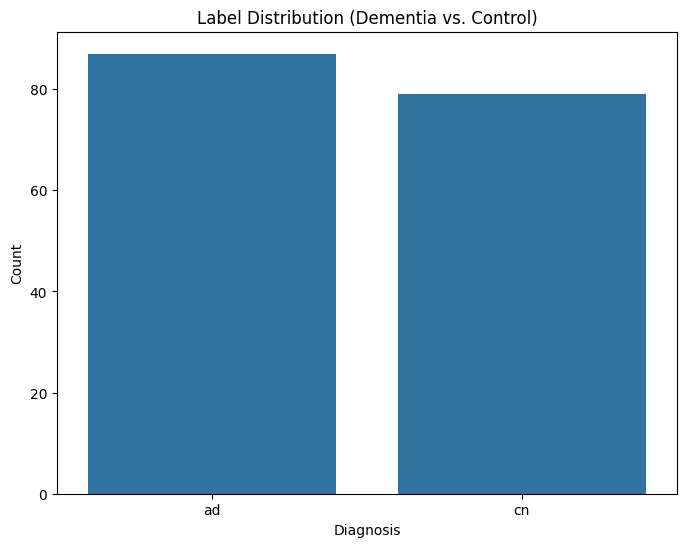

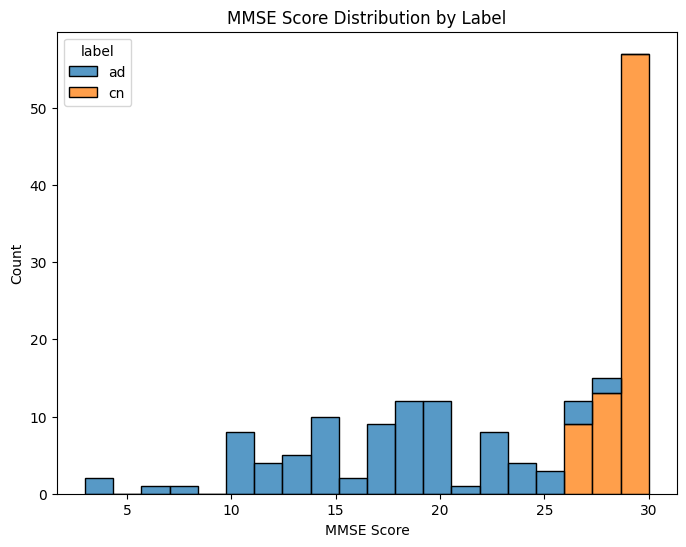

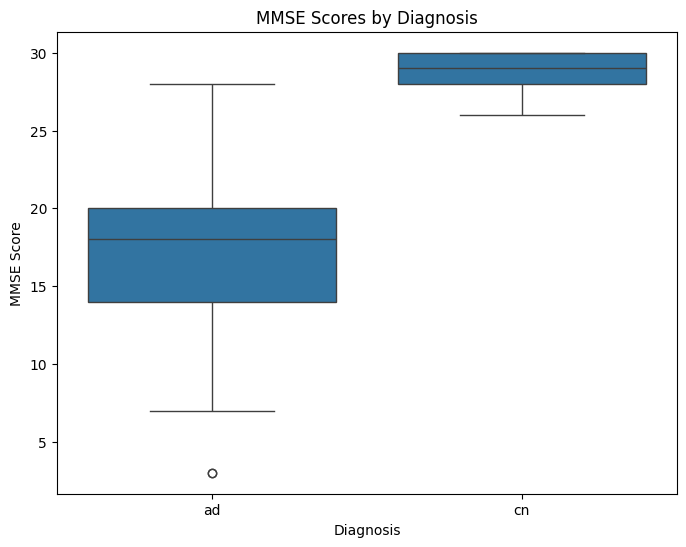

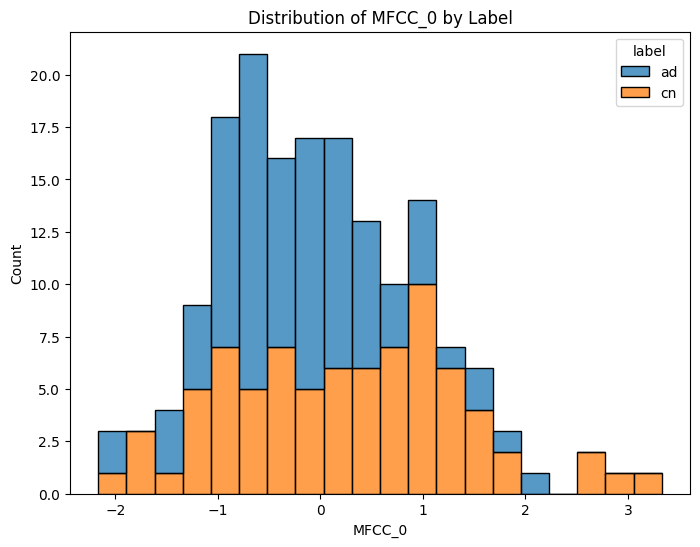

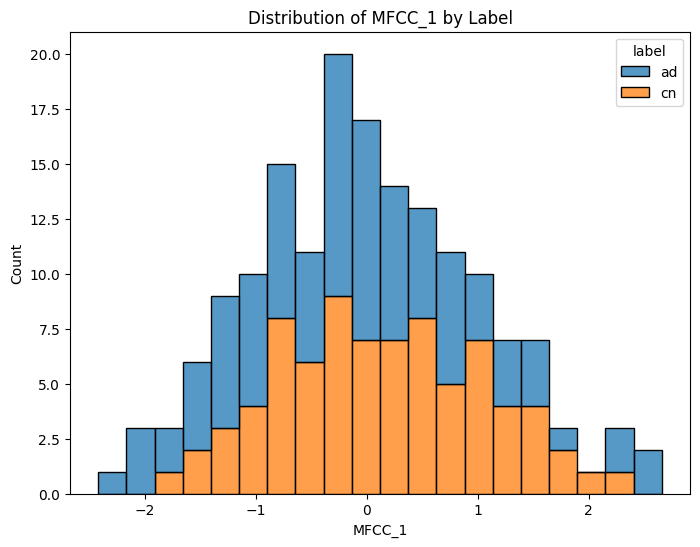

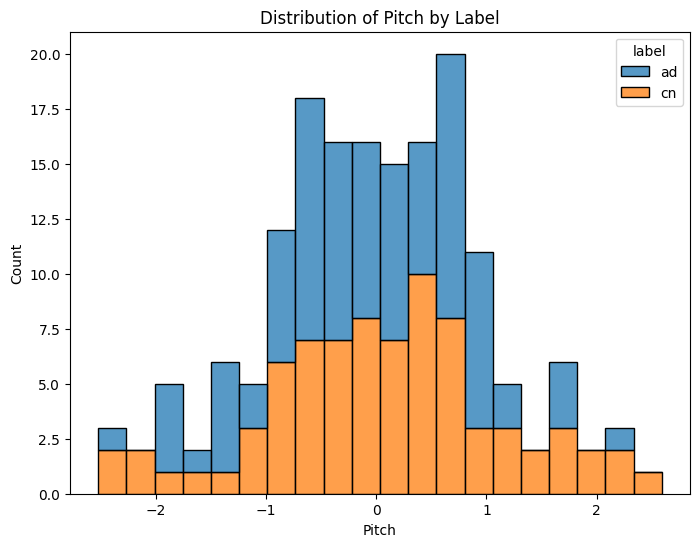

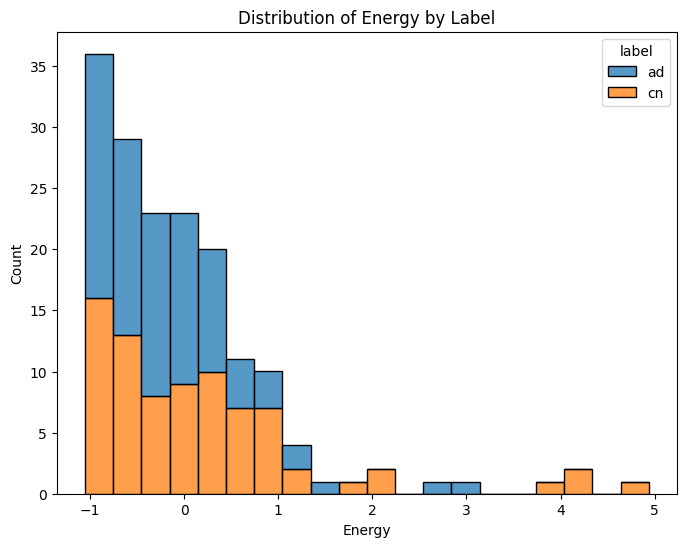

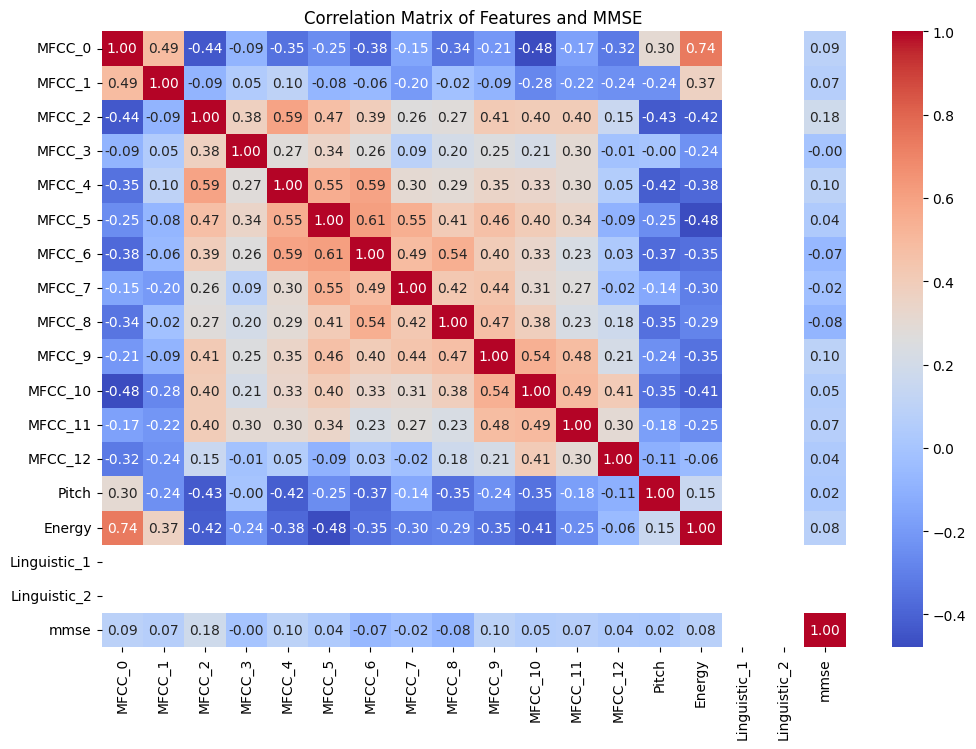

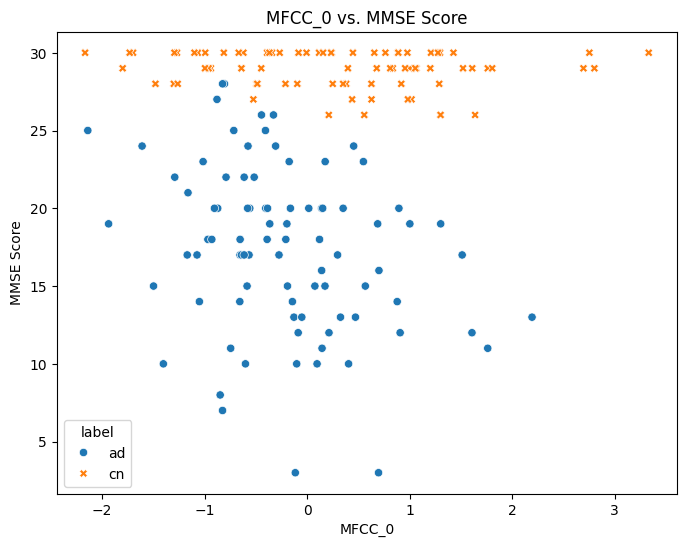

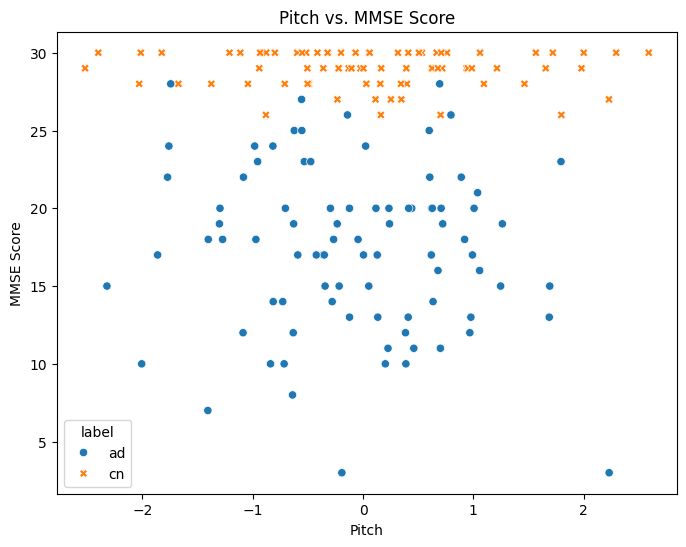

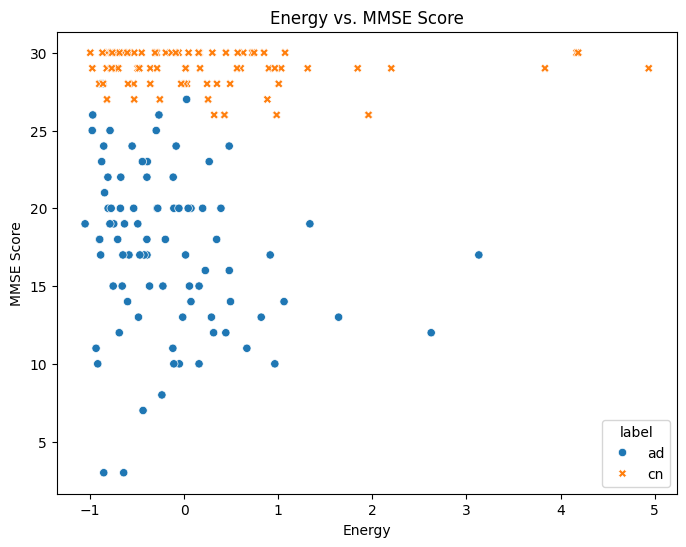

Calculating audio durations: 100%|██████████| 166/166 [00:14<00:00, 11.64it/s]


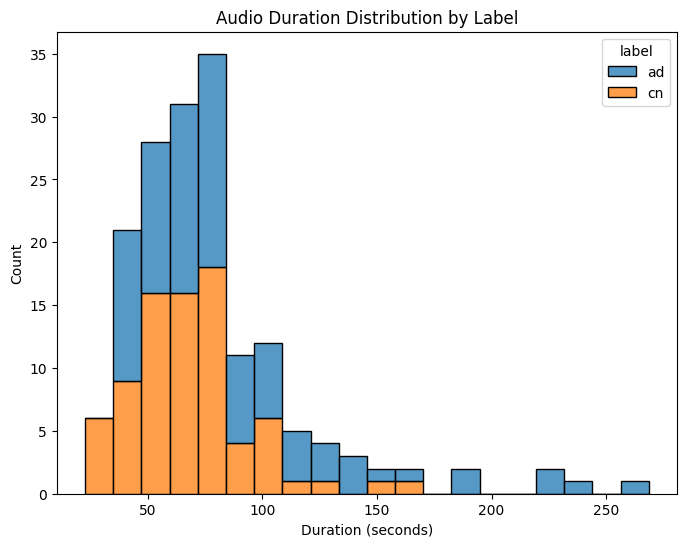

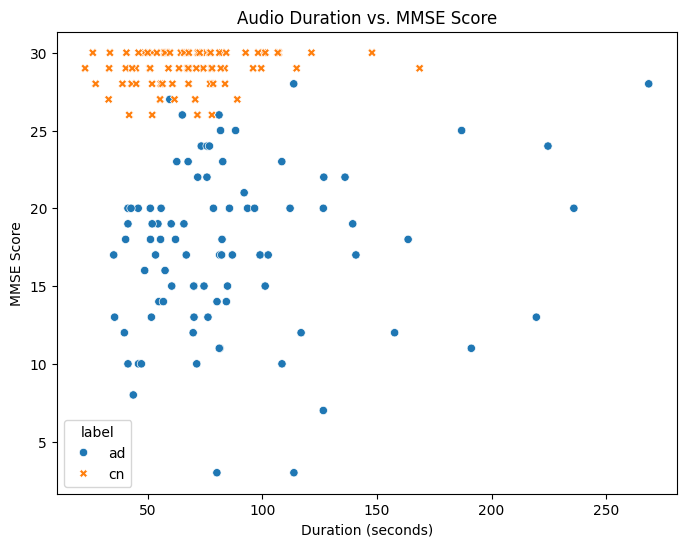

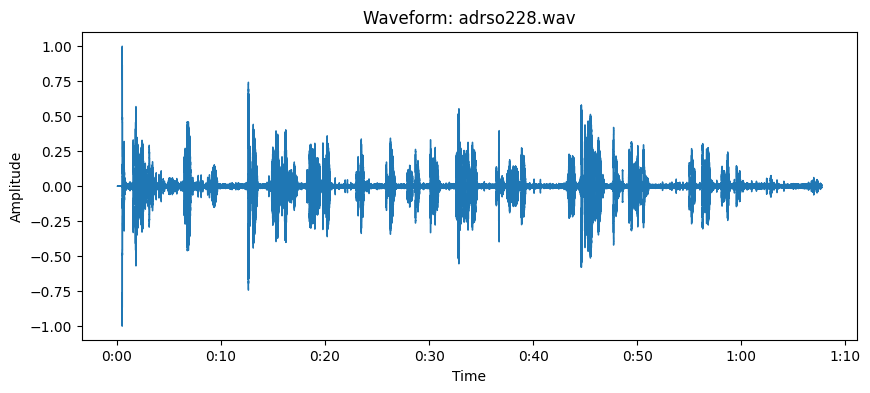

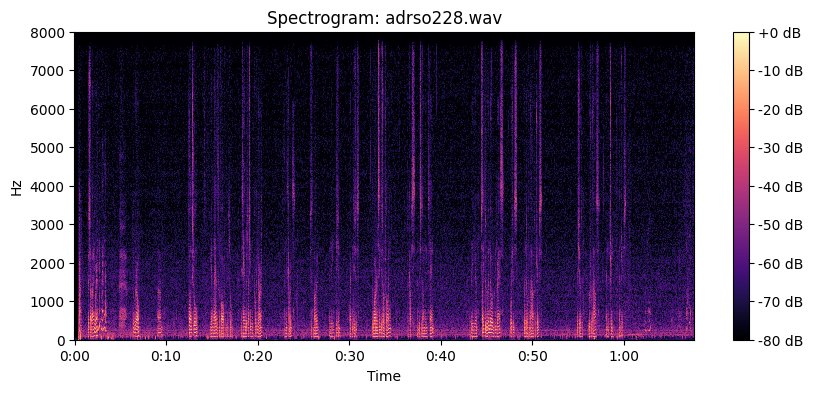

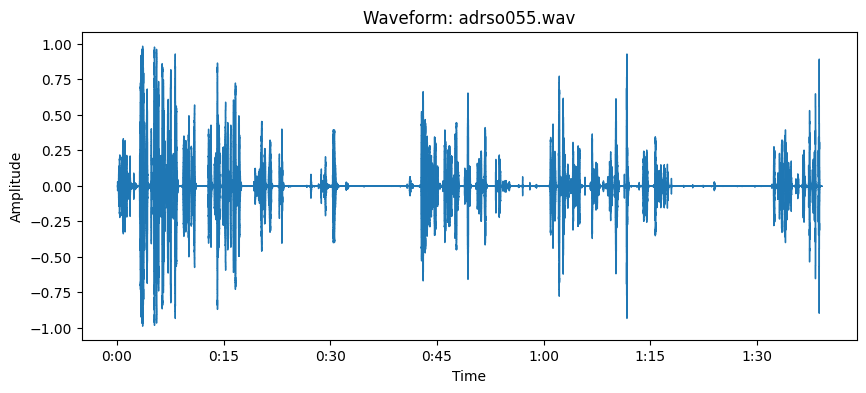

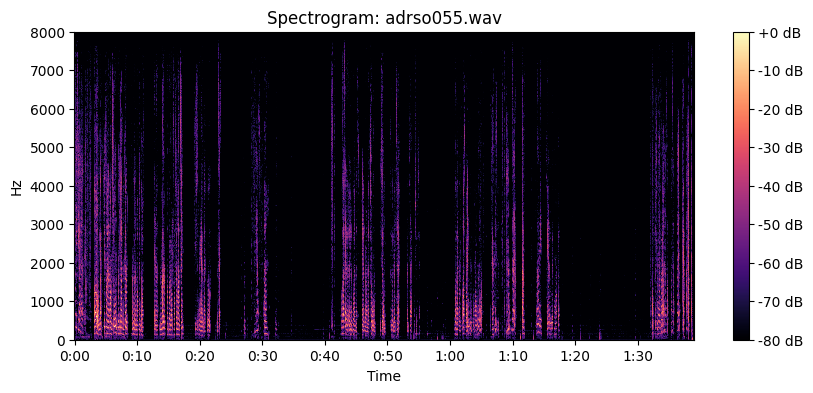

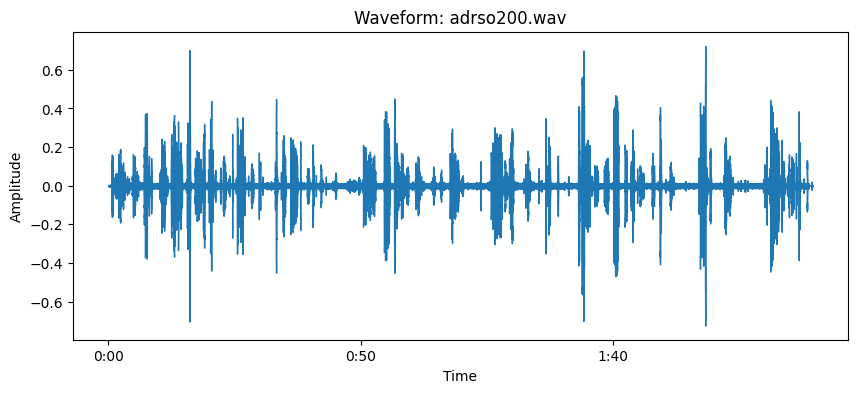

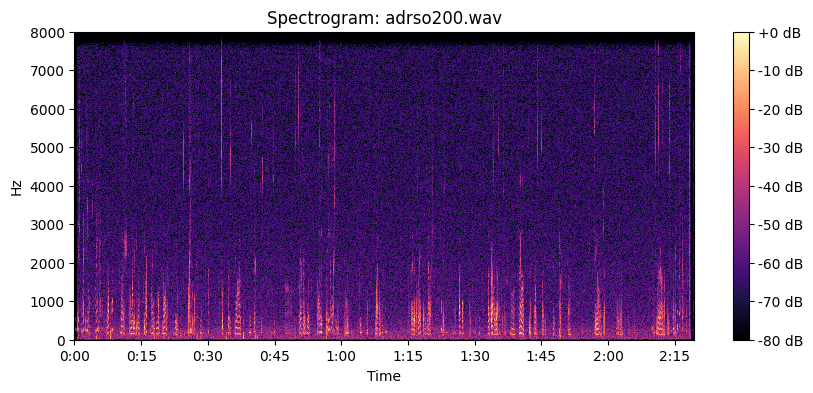

All EDA plots saved to /content/processed_features/eda_plots


In [17]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
eda_dir = os.path.join(output_dir, 'eda_plots')
os.makedirs(eda_dir, exist_ok=True)

# Load processed metadata and features
audio_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))
normalized_features = np.load(os.path.join(output_dir, 'normalized_features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))

# Convert features to DataFrame for easier analysis
feature_columns = [f'MFCC_{i}' for i in range(13)] + ['Pitch', 'Energy', 'Linguistic_1', 'Linguistic_2']
features_df = pd.DataFrame(normalized_features, columns=feature_columns)
features_df['label'] = labels
features_df['mmse'] = audio_metadata['mmse']

print("Features DataFrame preview:")
print(features_df.head())

# Step 1: Metadata Analysis
# 1.1 Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=audio_metadata, x='label')
plt.title('Label Distribution (Dementia vs. Control)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig(os.path.join(eda_dir, 'label_distribution.png'))
plt.show()

# 1.2 MMSE Score Distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=audio_metadata, x='mmse', hue='label', multiple='stack', bins=20)
plt.title('MMSE Score Distribution by Label')
plt.xlabel('MMSE Score')
plt.ylabel('Count')
plt.savefig(os.path.join(eda_dir, 'mmse_distribution.png'))
plt.show()

# 1.3 MMSE vs. Label (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(data=audio_metadata, x='label', y='mmse')
plt.title('MMSE Scores by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE Score')
plt.savefig(os.path.join(eda_dir, 'mmse_boxplot.png'))
plt.show()

# Step 2: Feature Analysis
# 2.1 Feature Distributions by Label
for feature in ['MFCC_0', 'MFCC_1', 'Pitch', 'Energy']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=features_df, x=feature, hue='label', multiple='stack', bins=20)
    plt.title(f'Distribution of {feature} by Label')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.savefig(os.path.join(eda_dir, f'{feature}_distribution.png'))
    plt.show()

# 2.2 Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = features_df[feature_columns + ['mmse']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features and MMSE')
plt.savefig(os.path.join(eda_dir, 'correlation_matrix.png'))
plt.show()

# 2.3 Feature vs. MMSE (Scatter Plots)
for feature in ['MFCC_0', 'Pitch', 'Energy']:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=features_df, x=feature, y='mmse', hue='label', style='label')
    plt.title(f'{feature} vs. MMSE Score')
    plt.xlabel(feature)
    plt.ylabel('MMSE Score')
    plt.savefig(os.path.join(eda_dir, f'{feature}_vs_mmse.png'))
    plt.show()

# Step 3: Audio Characteristics
# 3.1 Audio Duration Analysis
audio_durations = []
for file in tqdm(audio_metadata['file'], desc="Calculating audio durations"):
    try:
        y, sr = librosa.load(file, sr=16000)
        duration = librosa.get_duration(y=y, sr=sr)
        audio_durations.append(duration)
    except Exception as e:
        print(f"Error processing {file}: {e}")
        audio_durations.append(0)

audio_metadata['duration'] = audio_durations

# Plot duration distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=audio_metadata, x='duration', hue='label', multiple='stack', bins=20)
plt.title('Audio Duration Distribution by Label')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.savefig(os.path.join(eda_dir, 'duration_distribution.png'))
plt.show()

# Duration vs. MMSE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=audio_metadata, x='duration', y='mmse', hue='label', style='label')
plt.title('Audio Duration vs. MMSE Score')
plt.xlabel('Duration (seconds)')
plt.ylabel('MMSE Score')
plt.savefig(os.path.join(eda_dir, 'duration_vs_mmse.png'))
plt.show()

# 3.2 Waveform and Spectrogram for Sample Files
sample_files = audio_metadata['file'].head(3).tolist()
for file in sample_files:
    y, sr = librosa.load(file, sr=16000)

    # Waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {os.path.basename(file)}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.savefig(os.path.join(eda_dir, f'waveform_{os.path.basename(file)}.png'))
    plt.show()

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {os.path.basename(file)}')
    plt.savefig(os.path.join(eda_dir, f'spectrogram_{os.path.basename(file)}.png'))
    plt.show()

print(f"All EDA plots saved to {eda_dir}")

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define paths
output_dir = '/content/processed_features/'
eda_dir = os.path.join(output_dir, 'eda_plots')
os.makedirs(eda_dir, exist_ok=True)

# Load data
audio_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))
normalized_features = np.load(os.path.join(output_dir, 'normalized_features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))

# Verify shapes and content
print("Audio Metadata Shape:", audio_metadata.shape)
print("Features Shape:", normalized_features.shape)
print("Labels Shape:", labels.shape)
print("\nLabel Distribution:")
print(pd.Series(labels).value_counts())

# Preview data
print("\nAudio Metadata Preview:")
print(audio_metadata.head())
print("\nFeatures Preview:")
print(pd.DataFrame(normalized_features[:5], columns=[f'MFCC_{i}' for i in range(13)] + ['Pitch', 'Energy', 'Linguistic_1', 'Linguistic_2']).head())

Audio Metadata Shape: (166, 3)
Features Shape: (166, 17)
Labels Shape: (166,)

Label Distribution:
ad    87
cn    79
Name: count, dtype: int64

Audio Metadata Preview:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    23
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    19
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    10
4  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    20

Features Preview:
     MFCC_0    MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6  \
0  0.548086  1.123103  0.832806  1.697226  1.555941  0.958634  0.005304   
1 -0.275064 -1.498603 -1.105544 -0.947595 -0.747292 -0.224222 -0.202127   
2  0.687451 -0.003403  0.666319  0.281178  0.830952  1.004649  0.836760   
3  0.096259 -0.197817  0.053623 -1.312458 -0.054394  0.464454 -0.367433   
4 -0.872780 -1.477120 -0.735615 -0.283552  0.833


Feature Statistical Summary:
             MFCC_0        MFCC_1        MFCC_2        MFCC_3        MFCC_4  \
count  1.660000e+02  1.660000e+02  1.660000e+02  1.660000e+02  1.660000e+02   
mean  -2.140189e-16  1.819161e-16 -1.605142e-17  8.560756e-17  2.140189e-17   
std    1.003026e+00  1.003026e+00  1.003026e+00  1.003026e+00  1.003026e+00   
min   -2.166443e+00 -2.422847e+00 -3.138892e+00 -3.094411e+00 -2.703153e+00   
25%   -6.567078e-01 -6.924500e-01 -6.200255e-01 -6.333590e-01 -6.089798e-01   
50%   -1.092177e-01 -3.280998e-02  3.330428e-02  9.346716e-02  1.067502e-01   
75%    6.722757e-01  6.390794e-01  6.136036e-01  6.216003e-01  6.733926e-01   
max    3.331070e+00  2.659297e+00  3.089659e+00  2.608791e+00  2.094785e+00   

             MFCC_5        MFCC_6        MFCC_7      MFCC_8        MFCC_9  \
count  1.660000e+02  1.660000e+02  1.660000e+02  166.000000  1.660000e+02   
mean   2.140189e-17  8.560756e-17  7.490661e-17    0.000000  4.815425e-17   
std    1.003026e+00  1.0030

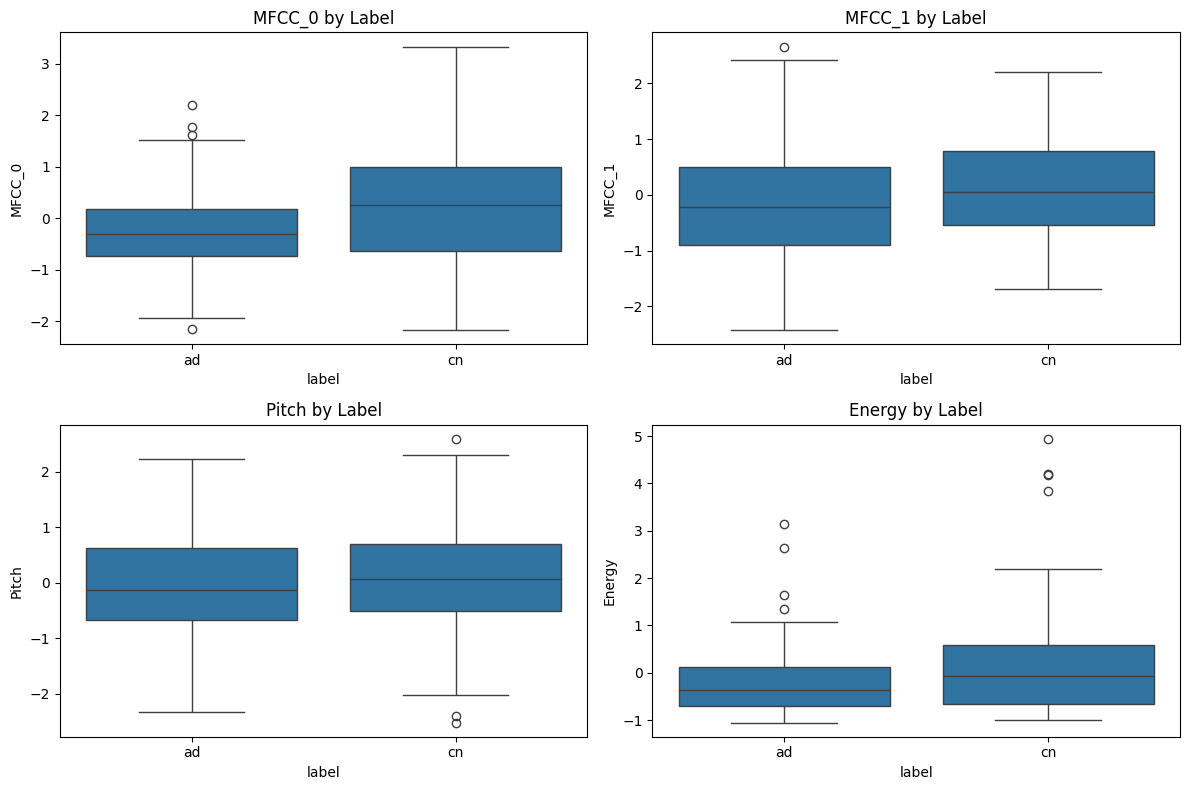

In [19]:
# Statistical summary
features_df = pd.DataFrame(normalized_features, columns=[f'MFCC_{i}' for i in range(13)] + ['Pitch', 'Energy', 'Linguistic_1', 'Linguistic_2'])
features_df['label'] = labels
features_df['mmse'] = audio_metadata['mmse']

print("\nFeature Statistical Summary:")
print(features_df.describe())

# Box plots for key features by label
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['MFCC_0', 'MFCC_1', 'Pitch', 'Energy'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.savefig(os.path.join(eda_dir, 'feature_boxplots.png'))
plt.show()

# Pairwise Feature Relationships

<Figure size 1000x800 with 0 Axes>

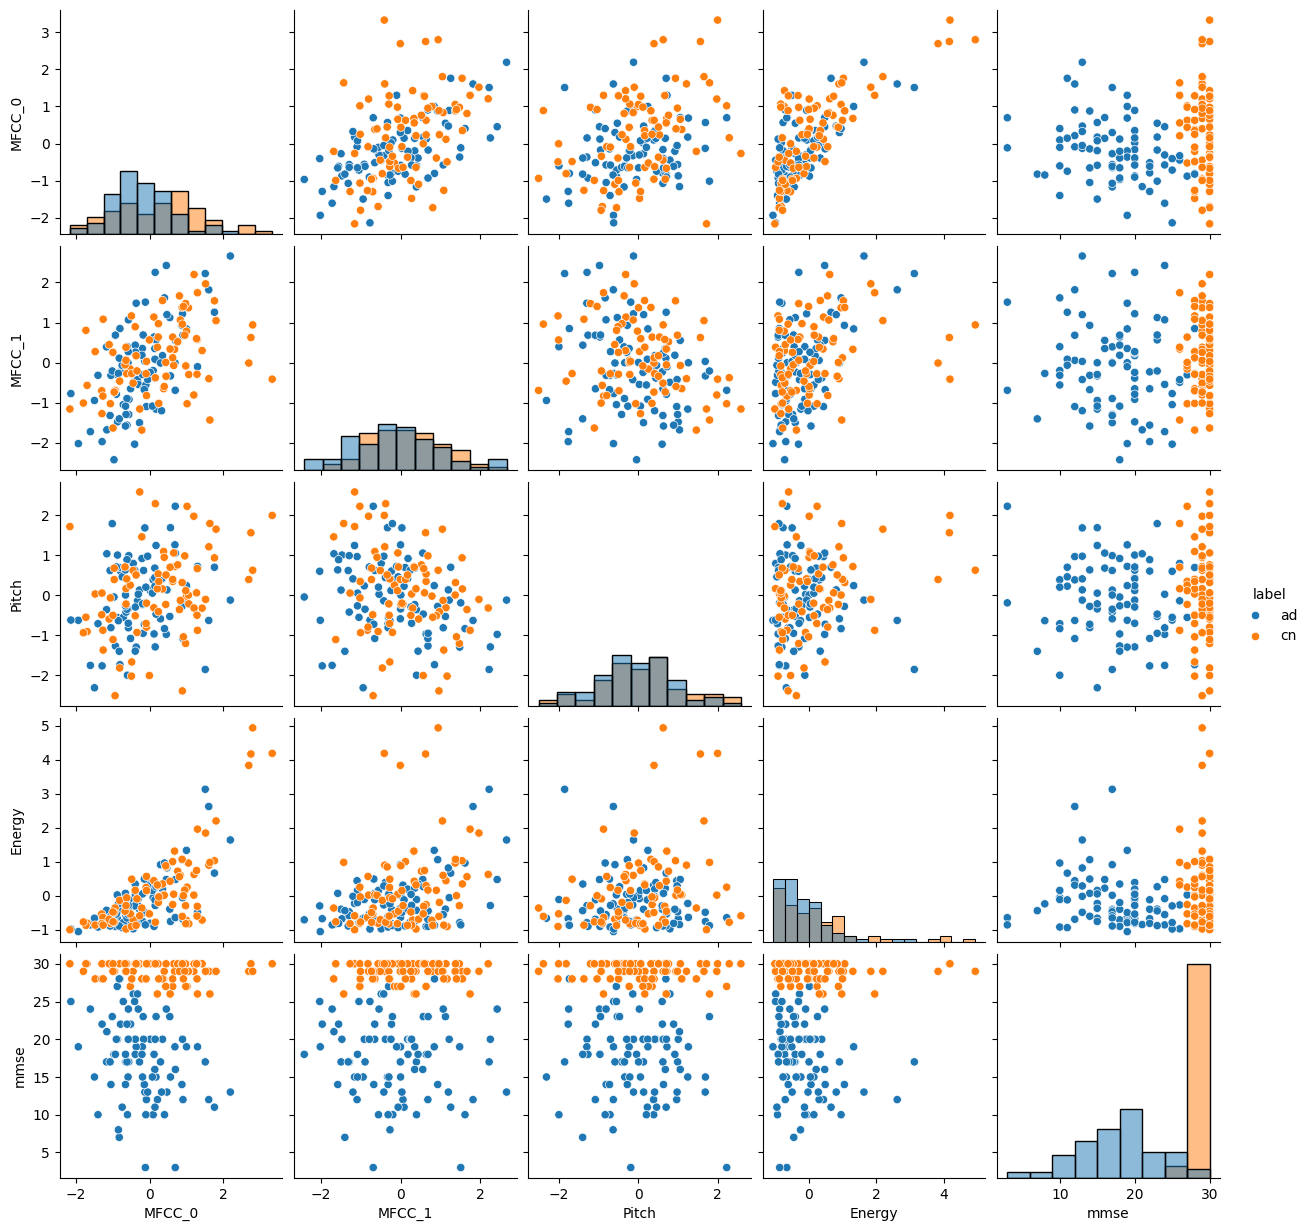

In [20]:
# Pairplot for key features
plt.figure(figsize=(10, 8))
sns.pairplot(features_df[['MFCC_0', 'MFCC_1', 'Pitch', 'Energy', 'mmse', 'label']], hue='label', diag_kind='hist')
plt.savefig(os.path.join(eda_dir, 'pairplot.png'))
plt.show()

# Audio Duration vs. Features

Calculating durations: 100%|██████████| 166/166 [00:16<00:00, 10.36it/s]


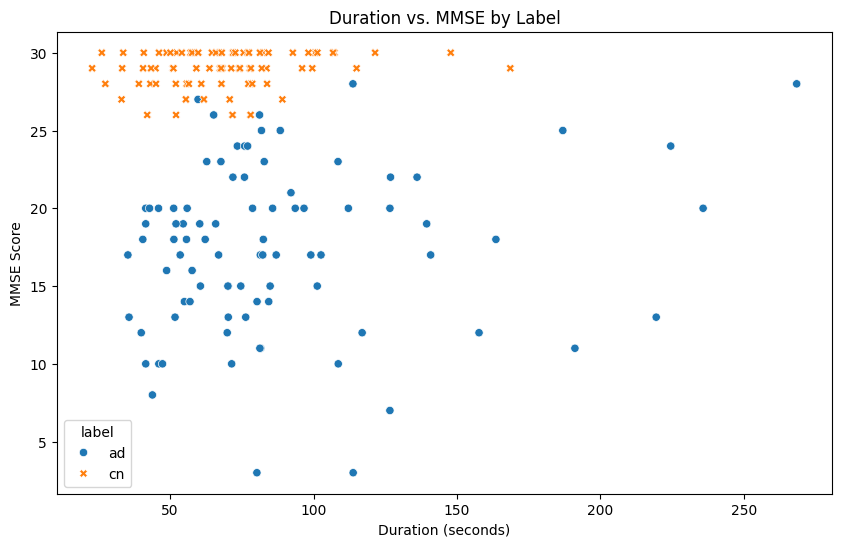

In [21]:
# Calculate durations
audio_durations = []
for file in tqdm(audio_metadata['file'], desc="Calculating durations"):
    y, sr = librosa.load(file, sr=16000)
    audio_durations.append(librosa.get_duration(y=y, sr=sr))

audio_metadata['duration'] = audio_durations

# Duration vs. MMSE and Label
plt.figure(figsize=(10, 6))
sns.scatterplot(data=audio_metadata, x='duration', y='mmse', hue='label', style='label')
plt.title('Duration vs. MMSE by Label')
plt.xlabel('Duration (seconds)')
plt.ylabel('MMSE Score')
plt.savefig(os.path.join(eda_dir, 'duration_vs_mmse.png'))
plt.show()

In [ ]:
!pip install torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 483.3/664.8 MB 7.3 MB/s eta 0:00:25